# Simple Neural Network Model

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

In [5]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=7, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 7, 27)

In [6]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [7]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])
    
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

## Splitting data into 70% train, 10% validation and 20% test

In [8]:
val_split = int(0.7 * x.shape[0])
test_split = int(0.8 * x.shape[0])

In [9]:
# Train
dates_for_training = days_to_recalculate[:val_split]
print(dates_for_training)

x_train = x[:val_split]
print(x_train.shape)
y_train = y[:val_split]
print(y_train.shape)

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2015-12-03', '2016-01-06', '2016-02-03', '2016-03-03',
               '2016-04-06', '2016-05-05', '2016-06-03', '2016-07-06',
               '2016-08-03', '2016-09-07'],
              dtype='datetime64[ns]', name='Days to rebalance', length=201, freq=None)
(201, 7, 27)
(201, 27)


In [10]:
# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
print(dates_for_validation)

x_val = x[val_split:test_split]
print(x_val.shape)
y_val = y[val_split:test_split]
print(y_val.shape)

DatetimeIndex(['2016-10-05', '2016-11-03', '2016-12-06', '2017-01-11',
               '2017-02-03', '2017-03-03', '2017-04-06', '2017-05-05',
               '2017-06-06', '2017-07-06', '2017-08-03', '2017-09-06',
               '2017-10-06', '2017-11-03', '2017-12-05', '2018-01-04',
               '2018-02-06', '2018-03-06', '2018-04-06', '2018-05-04',
               '2018-06-05', '2018-07-06', '2018-08-03', '2018-09-05',
               '2018-10-04', '2018-11-06', '2018-12-06', '2019-01-10',
               '2019-02-08'],
              dtype='datetime64[ns]', name='Days to rebalance', freq=None)
(29, 7, 27)
(29, 27)


In [11]:
# Test
dates_for_test = days_to_recalculate[test_split:]
print(dates_for_test)

x_test = x[test_split:]
print(x_test.shape)
y_test = y[test_split:]
print(y_test.shape)

DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
      

## Simple Dense Neural Network Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Dropout, GRU, LSTM, Bidirectional
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 189)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         3,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,499 (13.67 KB)

 Trainable params: 3,499 (13.67 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8274 - val_loss: 2.5700 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4903 - val_loss: 2.2566 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1849 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9106 - val_loss: 1.7230 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6657 - val_loss: 1.4998 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4491 - val_loss: 1.3026 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2576 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0897 - val_loss: 0.9769 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9423 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

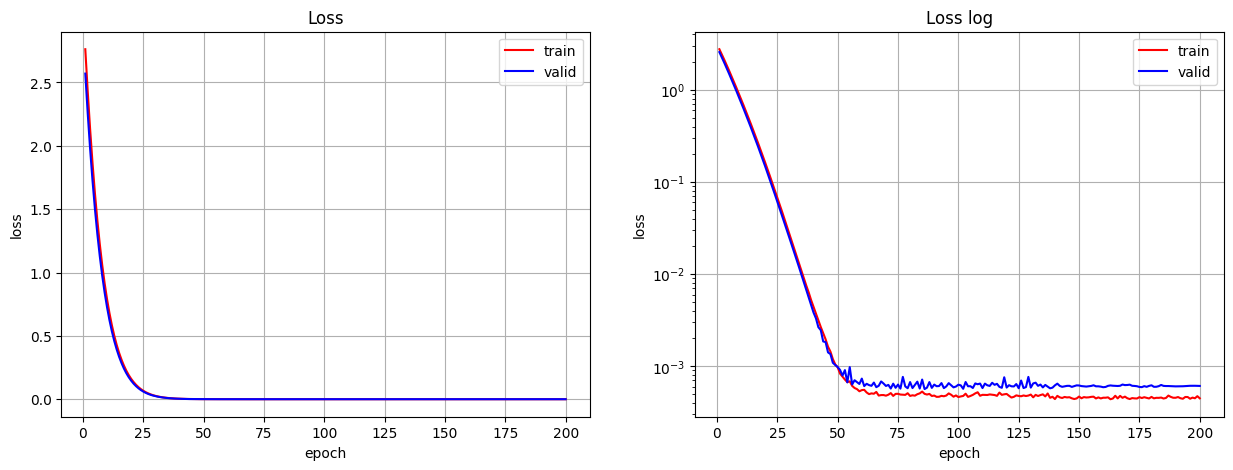

In [13]:
model_dnn = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn, x_train, y_train,
                         x_val, y_val, x_test, y_test)

In [14]:
predictions = model_dnn.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [15]:
predictions[0].round(3)

array([0.465, 0.081, 0.087, 0.032, 0.03 , 0.033, 0.028, 0.024, 0.011,
       0.014, 0.012, 0.012, 0.014, 0.009, 0.012, 0.01 , 0.009, 0.01 ,
       0.016, 0.01 , 0.013, 0.013, 0.011, 0.013, 0.012, 0.009, 0.009],
      dtype=float32)

In [16]:
y_test[0]

array([0.576, 0.046, 0.075, 0.023, 0.02 , 0.039, 0.017, 0.016, 0.007,
       0.008, 0.02 , 0.005, 0.02 , 0.02 , 0.004, 0.002, 0.002, 0.002,
       0.024, 0.025, 0.02 , 0.012, 0.006, 0.003, 0.004, 0.002, 0.002])

## Convolutional Neural Network Model

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 32)          │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,659 (22.11 KB)

 Trainable params: 5,659 (22.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5041 - val_loss: 7.7830 - learning_rate: 0.0010
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5653 - val_loss: 6.9068 - learning_rate: 0.0010
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7083 - val_loss: 6.1118 - learning_rate: 0.0010
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9316 - val_loss: 5.3952 - learning_rate: 0.0010
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2333 - val_loss: 4.7527 - learning_rate: 0.0010
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6076 - val_loss: 4.1791 - learning_rate: 0.0010
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0496 - val_loss: 3.6686 - learning_rate: 0.0010
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5533 - val_loss: 3.2151 - learning_rate: 0.0010
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1126 - val_loss: 2.8131 - learning_rate: 0.0010
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━

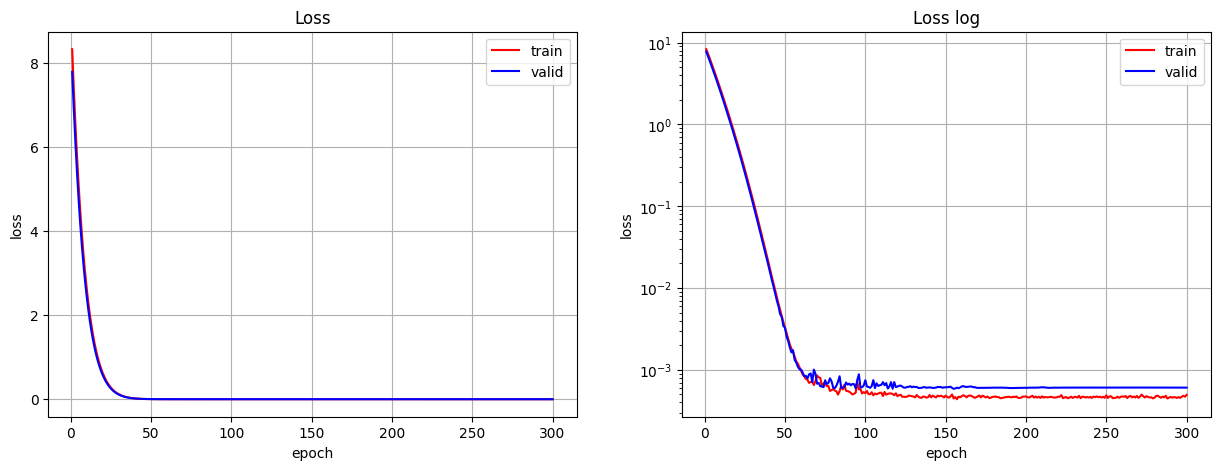

In [17]:
model_cnn = Sequential((
    Conv1D(32, 3, input_shape=x_train.shape[1:]),
    Flatten(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_cnn, x_train, y_train,
                         x_val, y_val, x_test, y_test, 
                         epochs=300)

## Model with GRU

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         5,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,843 (26.73 KB)

 Trainable params: 6,843 (26.73 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.1385 - val_loss: 2.0456 - learning_rate: 0.0010
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0152 - val_loss: 1.9262 - learning_rate: 0.0010
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8971 - val_loss: 1.8123 - learning_rate: 0.0010
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7849 - val_loss: 1.7041 - learning_rate: 0.0010
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6783 - val_loss: 1.6013 - learning_rate: 0.0010
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5771 - val_loss: 1.5038 - learning_rate: 0.0010
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4813 - val_loss: 1.4115 - learning_rate: 0.0010
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3911 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3054 - val_loss: 1.2431 - learning_rate: 0.0010
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━

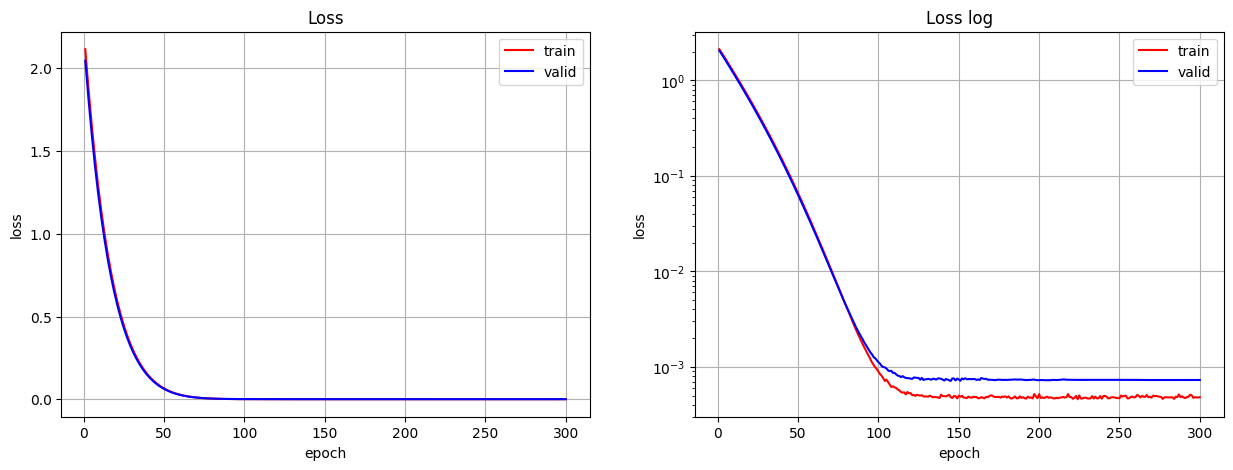

In [18]:
dropout = 0.1

model_gru = Sequential((
    GRU(32, input_shape=x_train.shape[1:],
         dropout=dropout, recurrent_dropout=dropout),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_gru, x_train, y_train,
                         x_val, y_val, x_test, y_test, 
                         epochs=300)

## Model with LSTM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,667 (33.86 KB)

 Trainable params: 8,667 (33.86 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.1219 - val_loss: 2.0284 - learning_rate: 0.0010
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9968 - val_loss: 1.9074 - learning_rate: 0.0010
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8773 - val_loss: 1.7922 - learning_rate: 0.0010
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7634 - val_loss: 1.6828 - learning_rate: 0.0010
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6557 - val_loss: 1.5792 - learning_rate: 0.0010
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5537 - val_loss: 1.4813 - learning_rate: 0.0010
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4568 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3662 - val_loss: 1.3015 - learning_rate: 0.0010
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2801 - val_loss: 1.2189 - learning_rate: 0.0010
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━

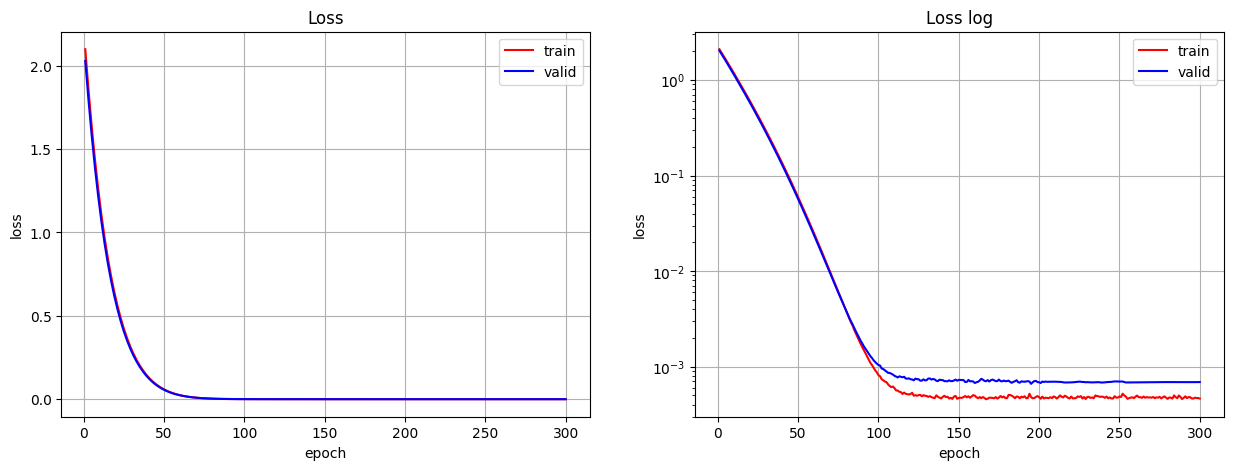

In [19]:
dropout = 0.1

model_lstm = Sequential((
    LSTM(32, input_shape=x_train.shape[1:],
         dropout=dropout, recurrent_dropout=dropout),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_lstm, x_train, y_train,
                         x_val, y_val, x_test, y_test, 
                         epochs=300)

## Model Bidireccional

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 32)          │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,379 (32.73 KB)

 Trainable params: 8,379 (32.73 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.9673 - val_loss: 2.6801 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5925 - val_loss: 2.3338 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2551 - val_loss: 2.0241 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9539 - val_loss: 1.7494 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6872 - val_loss: 1.5072 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4525 - val_loss: 1.2945 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2468 - val_loss: 1.1085 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0675 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9121 - val_loss: 0.8074 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

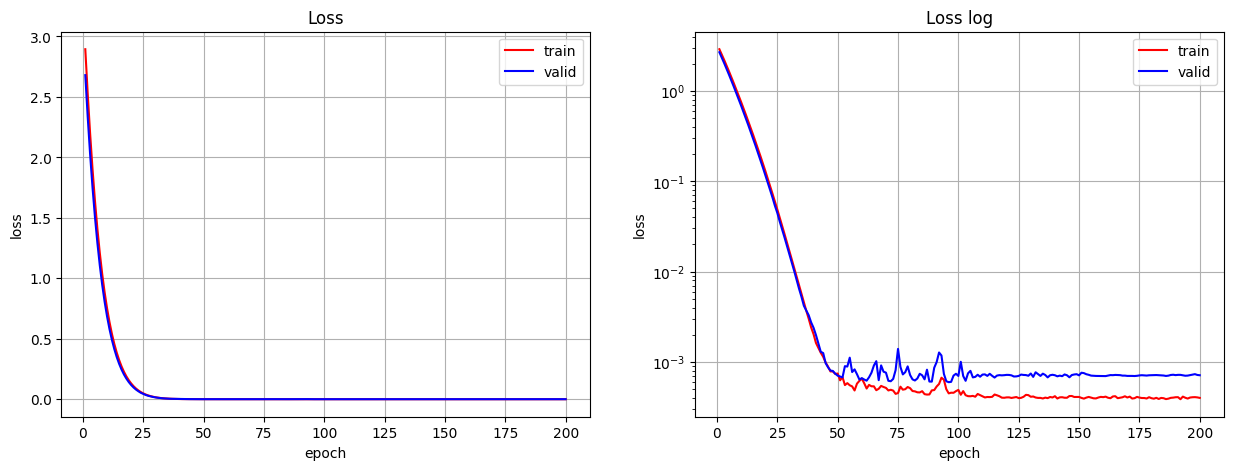

In [20]:
forward_layer = GRU(16, return_sequences=True)
backward_layer = GRU(16, activation='relu',
                     return_sequences=True,
                     go_backwards=True)

model_bidirectional = Sequential((
    Bidirectional(layer=forward_layer,
                  backward_layer=backward_layer,
                  input_shape=x_train.shape[1:]),
    Flatten(),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_bidirectional, 
                         x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

In [21]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [22]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [23]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [24]:
total_returns_model_dnn, cum_total_returns_model_dnn = calculate_returns_for_model(
    model_dnn, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [25]:
total_returns_model_cnn, cum_total_returns_model_cnn = calculate_returns_for_model(
    model_cnn, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [26]:
total_returns_model_gru, cum_total_returns_model_gru = calculate_returns_for_model(
    model_gru, x_test, dates_for_test, df_returns_test, selected_countries)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022D92103E20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [27]:
total_returns_model_lstm, cum_total_returns_model_lstm = calculate_returns_for_model(
    model_lstm, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [28]:
total_returns_model_bidirectional, cum_total_returns_model_bidirectional = calculate_returns_for_model(
    model_bidirectional, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


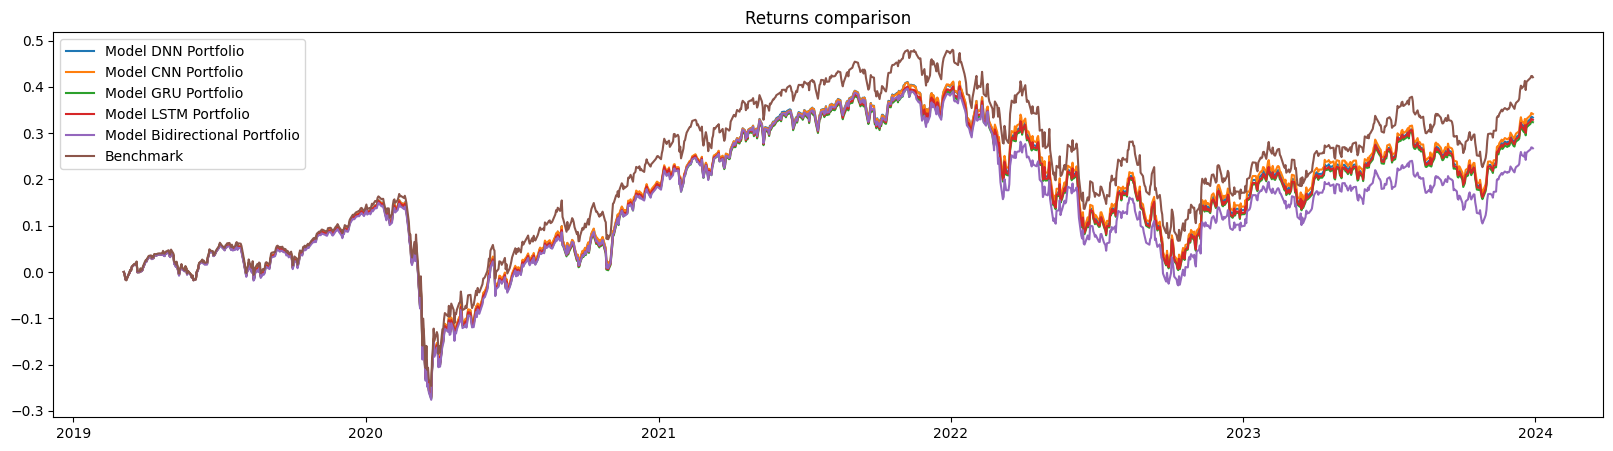

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(cum_total_returns_model_dnn, label='Model DNN Portfolio')
plt.plot(cum_total_returns_model_cnn, label='Model CNN Portfolio')
plt.plot(cum_total_returns_model_gru, label='Model GRU Portfolio')
plt.plot(cum_total_returns_model_lstm, label='Model LSTM Portfolio')
plt.plot(cum_total_returns_model_bidirectional, label='Model Bidirectional Portfolio')
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [30]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_model_dnn, df_results, 'Model DNN', benchmark_returns)
calculate_metrics(total_returns_model_cnn, df_results, 'Model CNN', benchmark_returns)
calculate_metrics(total_returns_model_gru, df_results, 'Model GRU', benchmark_returns)
calculate_metrics(total_returns_model_lstm, df_results, 'Model LSTM', benchmark_returns)
calculate_metrics(total_returns_model_bidirectional, df_results, 'Model Bidirectional', benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model DNN,0.061587,0.201658,0.305406,0.353058,-0.368469,493.0,0.167144,-0.569832
Model CNN,0.062851,0.200747,0.313085,0.362779,-0.366852,493.0,0.171325,-0.528163
Model GRU,0.059923,0.201737,0.297035,0.343453,-0.369604,493.0,0.162127,-0.609082
Model LSTM,0.060758,0.20184,0.301023,0.348231,-0.369148,493.0,0.164591,-0.583372
Model Bidirectional,0.050384,0.201101,0.250543,0.29002,-0.370213,538.0,0.136096,-0.726548
